In [17]:
from src.data_cleaning import clean_all
import pandas as pd
import networkx as nx
from networkx.algorithms import community as nx_comm
import seaborn as sns
from src.bipartie_graph_student_resource import build_student_activity_network
from src.bipartie_graph_student_resource import export_to_gephi, export_with_layout


In [18]:
# Load data
studentRegistration = pd.read_csv('../data/studentRegistration.csv')
studentInfo = pd.read_csv('../data/studentInfo.csv')
studentVle = pd.read_csv('../data/studentVle.csv')
studentAssessment = pd.read_csv('../data/studentAssessment.csv')
courses = pd.read_csv('../data/courses.csv')
vle = pd.read_csv('../data/vle.csv')
assessments = pd.read_csv('../data/assessments.csv')

In [19]:
# clean data
data = clean_all(studentInfo, studentAssessment, studentRegistration, 
                 studentVle, courses, vle, assessments)


In [20]:
# Construire le réseau (limité pour la visualisation)
print("Construction du réseau...")
G, interactions = build_student_activity_network(
    data, 
    module_code='BBB', 
    presentation='2013J',
    min_clicks=10,
    top_students=200
)

Construction du réseau...
Filtrage des données...
   → 2237 étudiants trouvés
   → 474272 interactions brutes
Agrégation par TYPE de ressource...
   → 9900 liens étudiant-type après filtrage
   → Limité aux 200 étudiants les plus actifs
Construction du graphe...
   → 200 étudiants + 12 types d'activités
   → 1413 arêtes créées
Réseau construit avec succès!



In [21]:
# Analyse l'importance de chaque TYPE de ressource
# Filtrer les nœuds d'activité
activities = {n for n, d in G.nodes(data=True) if d['node_type'] == 'activity'}
activity_metrics = []
for activity in activities:
    # Nombre d'étudiants utilisant ce type
    num_students = G.degree(activity)
    
    # Total des clics sur ce type
    total_clicks = sum(G[activity][neighbor]['weight'] for neighbor in G.neighbors(activity))
    
    # Clics moyens par étudiant
    avg_clicks = total_clicks / num_students if num_students > 0 else 0
    
    # Type d'activité
    activity_type = G.nodes[activity]['activity_type']
    
    activity_metrics.append({
        'activity_type': activity_type,
        'num_students': num_students,
        'total_clicks': total_clicks,
        'avg_clicks_per_student': avg_clicks,
        'popularity_score': num_students * avg_clicks  # Score composite
    })
    
df_activities = pd.DataFrame(activity_metrics)
df_activities = df_activities.sort_values('popularity_score', ascending=False)
print(df_activities.to_string(index=False))

activity_type  num_students  total_clicks  avg_clicks_per_student  popularity_score
      forumng           200        442842             2214.210000          442842.0
     homepage           200        149303              746.515000          149303.0
      subpage           200         24637              123.185000           24637.0
         quiz           200         24080              120.400000           24080.0
     resource           193         16997               88.067358           16997.0
    oucontent           188         14737               78.388298           14737.0
          url           191         11883               62.214660           11883.0
     glossary            23           332               14.434783             332.0
       ouwiki             2           239              119.500000             239.0
oucollaborate            10           198               19.800000             198.0
 externalquiz             3            53               17.666667           

In [22]:
# Identifie les PROFILS d'apprentissage des étudiants
students = {n for n, d in G.nodes(data=True) if d['node_type'] == 'student'}
student_profiles = []
for student in students:
    # Obtenir les activités utilisées
    activities = list(G.neighbors(student))
    
    # Créer le profil (% de clics par type)
    total_clicks = sum(G[student][activity]['weight'] for activity in activities)
    
    profile = {'student': student, 'final_result': G.nodes[student]['final_result']}
    
    for activity in activities:
        activity_type = G.nodes[activity]['activity_type']
        clicks = G[student][activity]['weight']
        profile[activity_type] = clicks / total_clicks if total_clicks > 0 else 0
    
    profile['total_clicks'] = total_clicks
    profile['diversity'] = len(activities)  # Nombre de types différents utilisés
    
    student_profiles.append(profile)

df_profiles = pd.DataFrame(student_profiles).fillna(0)
# Activité dominante pour chaque étudiant
activity_cols = [col for col in df_profiles.columns 
                 if col not in ['student', 'final_result', 'total_clicks', 'diversity']]

if activity_cols:
    df_profiles['dominant_activity'] = df_profiles[activity_cols].idxmax(axis=1)

print(f"   → {len(df_profiles)} profils créés")
print(f"   → Diversité moyenne: {df_profiles['diversity'].mean():.2f} types d'activités\n")

   → 200 profils créés
   → Diversité moyenne: 7.07 types d'activités



In [23]:
# Compare les résultats selon l'activité dominante
# Grouper par activité dominante et résultat
success_by_activity = df_profiles.groupby(['dominant_activity', 'final_result']).size().unstack(fill_value=0)

# Calculer le taux de réussite (Pass + Distinction)
if 'Pass' in success_by_activity.columns or 'Distinction' in success_by_activity.columns:
    success_cols = [col for col in ['Pass', 'Distinction'] if col in success_by_activity.columns]
    success_by_activity['success_rate'] = success_by_activity[success_cols].sum(axis=1) / success_by_activity.sum(axis=1)

print(success_by_activity)

final_result       Distinction  Fail  Pass  Withdrawn  success_rate
dominant_activity                                                  
forumng                     46    12   120         10      0.882979
homepage                     0     1     7          0      0.875000
oucontent                    0     1     0          1      0.000000
resource                     0     0     1          0      1.000000
subpage                      0     0     0          1      0.000000


In [24]:
# Identifie les étudiants à risque
# Seuils de risque
threshold_percentile=25
click_threshold = df_profiles['total_clicks'].quantile(threshold_percentile/100)
diversity_threshold = df_profiles['diversity'].quantile(threshold_percentile/100)

df_profiles['at_risk'] = (
    (df_profiles['total_clicks'] < click_threshold) | 
    (df_profiles['diversity'] < diversity_threshold)
)

at_risk = df_profiles[df_profiles['at_risk']]

print(f"   → {len(at_risk)} étudiants à risque identifiés ({len(at_risk)/len(df_profiles)*100:.1f}%)")
print(f"   → Seuil clics: {click_threshold:.0f}")
print(f"   → Seuil diversité: {diversity_threshold:.1f}\n")

   → 65 étudiants à risque identifiés (32.5%)
   → Seuil clics: 1916
   → Seuil diversité: 7.0



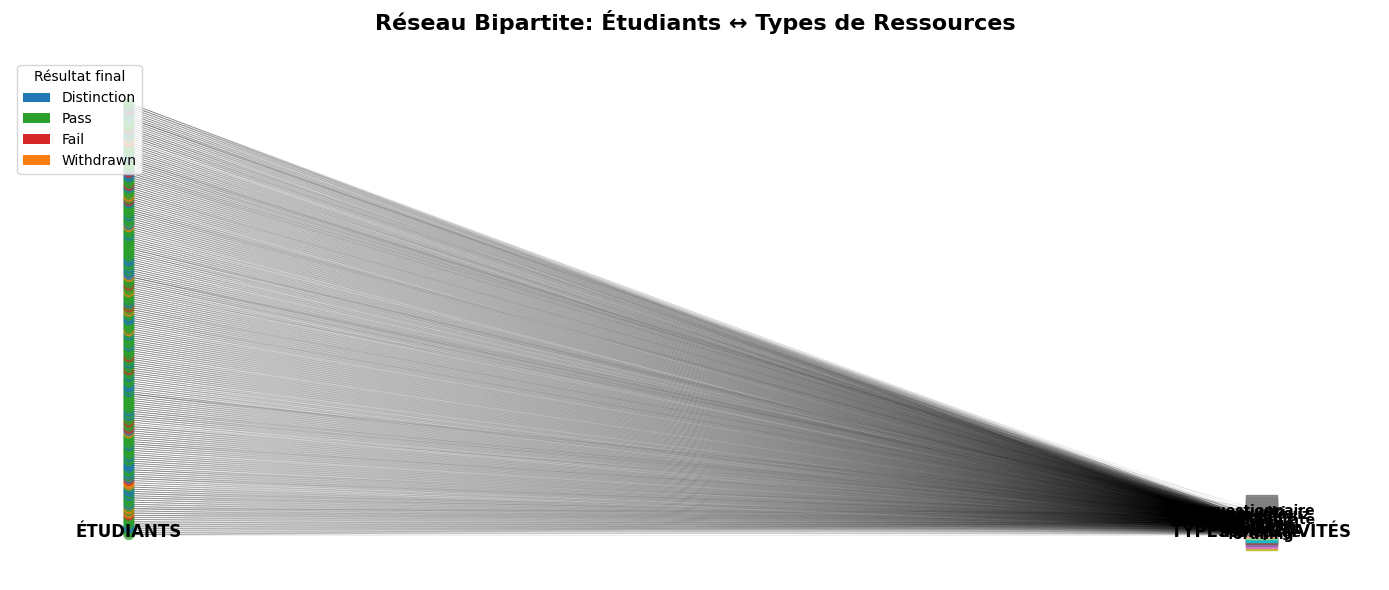

In [25]:
# Visualisation claire du réseau bipartite
# Gauche = Étudiants (colorés par résultat)
# Droite = Types d'activités

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14, 6))

# Séparer les nœuds
students = [n for n, d in G.nodes(data=True) if d['node_type'] == 'student']
activities = [n for n, d in G.nodes(data=True) if d['node_type'] == 'activity']

# Layout bipartite (deux colonnes)
pos = {}
pos.update((node, (0, idx)) for idx, node in enumerate(students))
pos.update((node, (2, idx)) for idx, node in enumerate(activities))

# Couleurs des étudiants selon résultat
result_colors = {
    'Distinction': '#1f77b4',  # Bleu
    'Pass': '#2ca02c',          # Vert
    'Fail': '#d62728',          # Rouge
    'Withdrawn': '#ff7f0e'      # Orange
}
student_colors = [result_colors.get(G.nodes[s].get('final_result', 'Fail'), 'gray') 
                 for s in students]

# Couleurs des activités (palette distinctive)
activity_color_map = {
    'homepage': '#e377c2',
    'resource': '#17becf',
    'forumng': '#bcbd22',
    'oucontent': '#9467bd',
    'quiz': '#8c564b',
    'url': '#ff9896',
    'subpage': '#98df8a',
    'page': '#c5b0d5'
}
activity_colors = [activity_color_map.get(G.nodes[a].get('activity_type', 'resource'), 'gray') 
                  for a in activities]

# Dessiner les nœuds
nx.draw_networkx_nodes(G, pos, nodelist=students, node_color=student_colors, 
                      node_size=50, alpha=0.6, ax=ax)
nx.draw_networkx_nodes(G, pos, nodelist=activities, node_color=activity_colors, 
                      node_size=500, alpha=0.9, node_shape='s', ax=ax)

# Labels pour les activités seulement
activity_labels = {n: G.nodes[n]['activity_type'] for n in activities}
nx.draw_networkx_labels(G, pos, labels=activity_labels, font_size=10, font_weight='bold', ax=ax)

# Arêtes avec transparence
nx.draw_networkx_edges(G, pos, alpha=0.1, width=0.5, ax=ax)

ax.set_title('Réseau Bipartite: Étudiants ↔ Types de Ressources', 
             fontsize=16, fontweight='bold', pad=20)
ax.text(0, -1, 'ÉTUDIANTS', ha='center', fontsize=12, fontweight='bold')
ax.text(2, -1, 'TYPES D\'ACTIVITÉS', ha='center', fontsize=12, fontweight='bold')

# Légende
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=result_colors['Distinction'], label='Distinction'),
    Patch(facecolor=result_colors['Pass'], label='Pass'),
    Patch(facecolor=result_colors['Fail'], label='Fail'),
    Patch(facecolor=result_colors['Withdrawn'], label='Withdrawn')
]
ax.legend(handles=legend_elements, loc='upper left', title='Résultat final')

ax.axis('off')
plt.tight_layout()

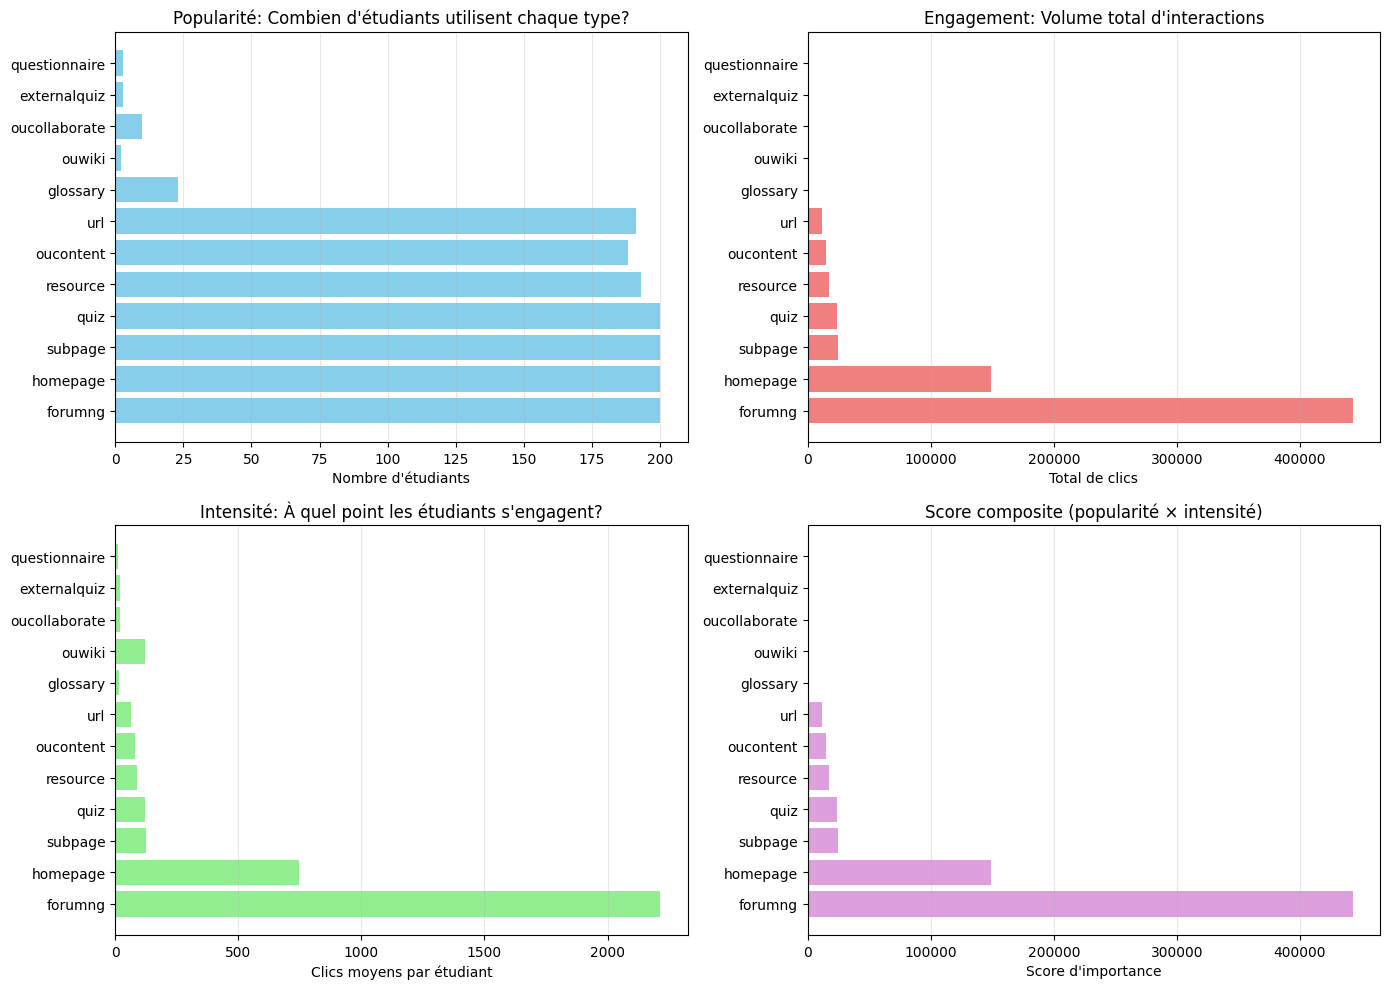

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Popularité (nombre d'étudiants)
axes[0, 0].barh(df_activities['activity_type'], 
                df_activities['num_students'], 
                color='skyblue')
axes[0, 0].set_xlabel('Nombre d\'étudiants')
axes[0, 0].set_title('Popularité: Combien d\'étudiants utilisent chaque type?')
axes[0, 0].grid(axis='x', alpha=0.3)

# 2. Engagement total (clics totaux)
axes[0, 1].barh(df_activities['activity_type'], 
                df_activities['total_clicks'], 
                color='lightcoral')
axes[0, 1].set_xlabel('Total de clics')
axes[0, 1].set_title('Engagement: Volume total d\'interactions')
axes[0, 1].grid(axis='x', alpha=0.3)

# 3. Intensité (clics moyens par étudiant)
axes[1, 0].barh(df_activities['activity_type'], 
                df_activities['avg_clicks_per_student'], 
                color='lightgreen')
axes[1, 0].set_xlabel('Clics moyens par étudiant')
axes[1, 0].set_title('Intensité: À quel point les étudiants s\'engagent?')
axes[1, 0].grid(axis='x', alpha=0.3)

# 4. Score composite
axes[1, 1].barh(df_activities['activity_type'], 
                df_activities['popularity_score'], 
                color='plum')
axes[1, 1].set_xlabel('Score d\'importance')
axes[1, 1].set_title('Score composite (popularité × intensité)')
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()

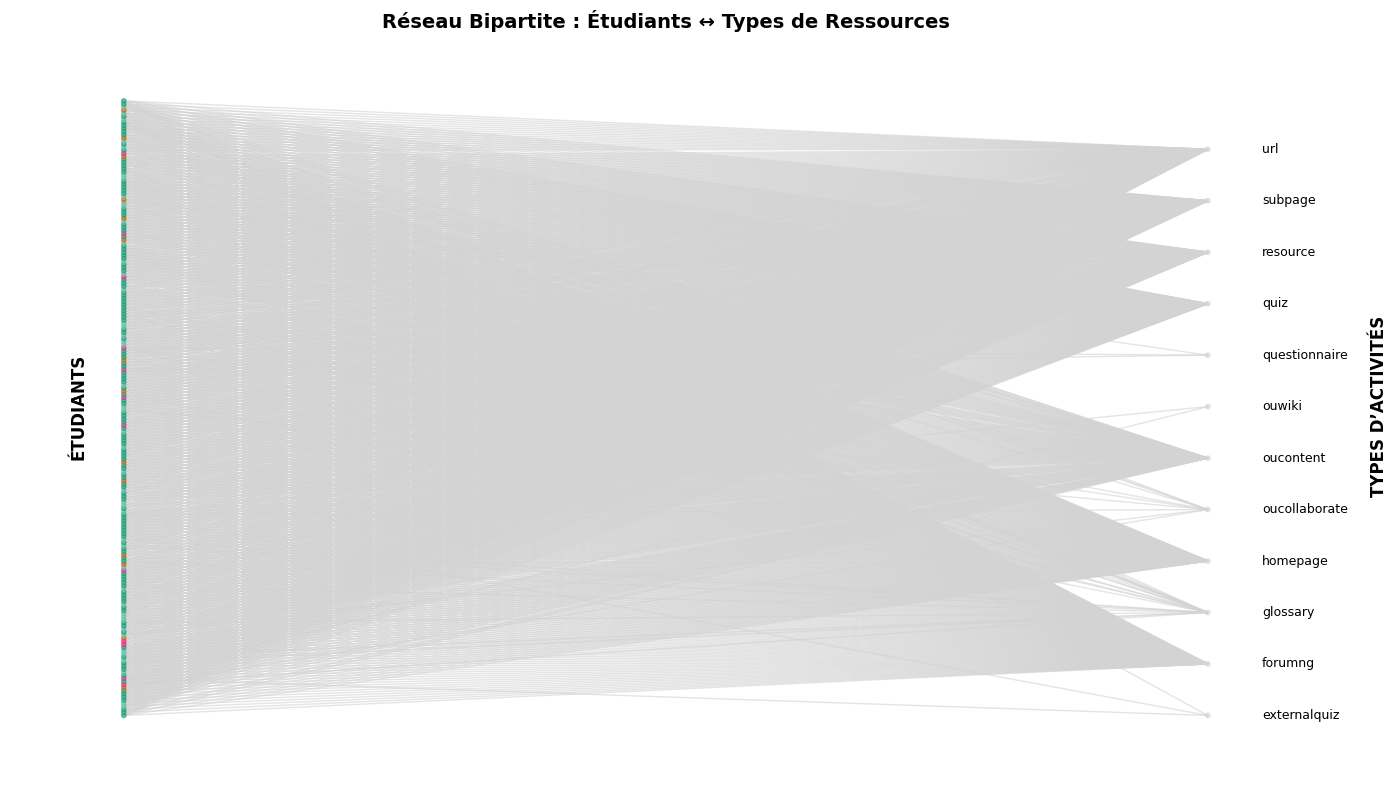

In [27]:

B = G.copy()

students = [n for n, d in B.nodes(data=True) if d.get('bipartite') == 0]
activities = [n for n, d in B.nodes(data=True) if d.get('bipartite') == 1]

activity_types = sorted(list(set([B.nodes[a]['activity_type'] for a in activities])))
activity_y = {t: i for i, t in enumerate(activity_types)}

# Positionner les nœuds
pos = {}

# Étudiants alignés à gauche
for i, s in enumerate(students):
    pos[s] = (0, i)

# Activités groupées par type à droite
for a in activities:
    pos[a] = (1, activity_y[B.nodes[a]['activity_type']] * len(students) / len(activity_types))


color_map = {
    'Distinction': '#66c2a5',
    'Pass': '#1b9e77',
    'Fail': '#d95f02',
    'Withdrawn': '#e7298a'
}
node_colors = [color_map.get(B.nodes[n].get('final_result'), 'gray') if n in students else 'lightgray' for n in B.nodes()]

fig, ax = plt.subplots(figsize=(14, 8))

nx.draw(
    B, pos, 
    node_size=10, 
    edge_color='lightgray', 
    node_color=node_colors, 
    with_labels=False, 
    alpha=0.6,
    ax=ax
)

# Labels groupés pour les activités
for t, y in activity_y.items():
    ax.text(1.05, y * len(students) / len(activity_types), t, fontsize=9, va='center')

ax.text(-0.05, len(students)/2, "ÉTUDIANTS", fontsize=12, fontweight="bold", rotation=90, va='center')
ax.text(1.15, len(students)/2, "TYPES D’ACTIVITÉS", fontsize=12, fontweight="bold", rotation=90, va='center')
ax.set_title("Réseau Bipartite : Étudiants ↔ Types de Ressources", fontsize=14, fontweight="bold")
ax.axis('off')

plt.tight_layout()
plt.show()


In [28]:
# export_to_gephi
export_to_gephi(G)
export_with_layout(G)


💾 Export pour Gephi...
   ✅ Fichier GEXF créé: student_network.gexf
   ✅ Fichier GraphML créé: student_network.graphml
   ✅ Fichier CSV arêtes créé: student_network_edges.csv
   ✅ Fichier CSV nœuds créé: student_network_nodes.csv

📊 Pour ouvrir dans Gephi:
   1. Ouvrir Gephi
   2. File → Open → Sélectionner 'student_network.gexf'
   3. Dans 'Appearance', colorier par 'final_result' ou 'node_type'
   4. Appliquer un layout (ForceAtlas2 recommandé)
   5. Calculer les statistiques réseau (Tools → Statistics)

💾 Export avec layout bipartite...
   ✅ Fichier avec layout créé: student_network_with_layout.gexf
   → Gephi gardera ce layout bipartite!



'student_network_with_layout.gexf'

## Détection de communauté

In [55]:
#  Détection de communautés avec Louvain
    
import community as community_louvain


G_proj = G.copy()

# Détection
communities = community_louvain.best_partition(G_proj, weight='weight')

# Ajouter comme attribut
nx.set_node_attributes(G_proj, communities, 'community')

# Statistiques
num_communities = len(set(communities.values()))
modularity = community_louvain.modularity(communities, G_proj, weight='weight')

print(f"   → {num_communities} communautés détectées")
print(f"   → Modularité : {modularity:.3f} (>0.3 = bonne structure)")

# Distribution par communauté
from collections import Counter
community_sizes = Counter(communities.values())
print(f"   → Tailles : {dict(community_sizes)}\n")


   → 2 communautés détectées
   → Modularité : 0.119 (>0.3 = bonne structure)
   → Tailles : {1: 122, 0: 90}



In [56]:
comm_data = []
for node, comm_id in communities.items():
    final_result = G_proj.nodes[node].get('final_result', 'Unknown')
    gender = G_proj.nodes[node].get('gender', 'Unknown')
    age_band = G_proj.nodes[node].get('age_band', 'Unknown')
    
    comm_data.append({
        'node': node,
        'community': comm_id,
        'final_result': final_result,
        'gender': gender,
        'age_band': age_band
    })

df_comm = pd.DataFrame(comm_data)

# Analyser par communauté
print("\nProfil de chaque communauté:")
for comm_id in sorted(df_comm['community'].unique()):
    comm_subset = df_comm[df_comm['community'] == comm_id]
    print(f"\n--- Communauté {comm_id} ({len(comm_subset)} étudiants) ---")
    
    # Distribution des résultats
    result_dist = comm_subset['final_result'].value_counts()
    print(f"Résultats: {result_dist.to_dict()}")
    
    # Taux de réussite
    pass_rate = (result_dist.get('Pass', 0) + result_dist.get('Distinction', 0)) / len(comm_subset) * 100
    print(f"Taux de réussite: {pass_rate:.1f}%")


Profil de chaque communauté:

--- Communauté 0 (90 étudiants) ---
Résultats: {'Pass': 60, 'Distinction': 18, 'Withdrawn': 5, 'Fail': 5, 'Unknown': 2}
Taux de réussite: 86.7%

--- Communauté 1 (122 étudiants) ---
Résultats: {'Pass': 68, 'Distinction': 28, 'Unknown': 10, 'Fail': 9, 'Withdrawn': 7}
Taux de réussite: 78.7%


Text(0.5, 0.98, 'Analyse des Profils de Communautés')

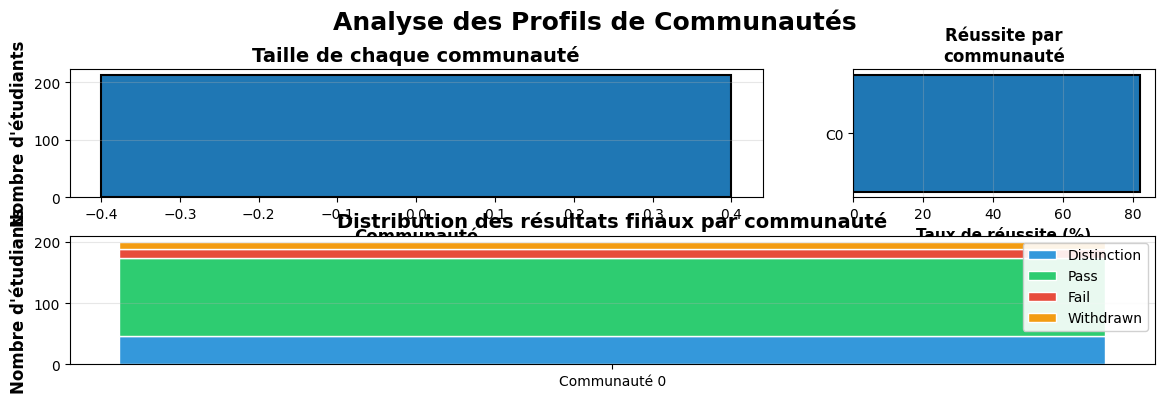

In [46]:

import numpy as np    
num_communities = df_comm['community'].nunique()

# Créer une figure avec plusieurs subplots
fig = plt.figure(figsize=(14,6))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Distribution des communautés
ax1 = fig.add_subplot(gs[0, :2])
comm_counts = df_comm['community'].value_counts().sort_index()
colors = plt.cm.tab10(range(len(comm_counts)))
ax1.bar(comm_counts.index, comm_counts.values, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Communauté', fontsize=12, fontweight='bold')
ax1.set_ylabel('Nombre d\'étudiants', fontsize=12, fontweight='bold')
ax1.set_title('Taille de chaque communauté', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# 2. Taux de réussite par communauté
ax2 = fig.add_subplot(gs[0, 2])
success_rates = []
for comm_id in sorted(df_comm['community'].unique()):
    comm_subset = df_comm[df_comm['community'] == comm_id]
    result_dist = comm_subset['final_result'].value_counts()
    success = result_dist.get('Pass', 0) + result_dist.get('Distinction', 0)
    rate = success / len(comm_subset) * 100
    success_rates.append(rate)

ax2.barh(range(len(success_rates)), success_rates, color=colors, edgecolor='black', linewidth=1.5)
ax2.set_yticks(range(len(success_rates)))
ax2.set_yticklabels([f'C{i}' for i in range(len(success_rates))])
ax2.set_xlabel('Taux de réussite (%)', fontsize=11, fontweight='bold')
ax2.set_title('Réussite par\ncommunauté', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# 3. Distribution des résultats par communauté (stacked bar)
ax3 = fig.add_subplot(gs[1, :])
result_order = ['Distinction', 'Pass', 'Fail', 'Withdrawn']
result_colors_map = {'Distinction': '#3498db', 'Pass': '#2ecc71', 
                     'Fail': '#e74c3c', 'Withdrawn': '#f39c12'}

comm_results = {}
for comm_id in sorted(df_comm['community'].unique()):
    comm_subset = df_comm[df_comm['community'] == comm_id]
    result_dist = comm_subset['final_result'].value_counts()
    comm_results[comm_id] = {r: result_dist.get(r, 0) for r in result_order}

# Stacked bar chart
bottom = np.zeros(len(comm_results))
for result in result_order:
    values = [comm_results[c][result] for c in sorted(comm_results.keys())]
    ax3.bar(range(len(comm_results)), values, bottom=bottom, 
           label=result, color=result_colors_map[result], 
           edgecolor='white', linewidth=1)
    bottom += values

ax3.set_xticks(range(len(comm_results)))
ax3.set_xticklabels([f'Communauté {i}' for i in sorted(comm_results.keys())])
ax3.set_ylabel('Nombre d\'étudiants', fontsize=12, fontweight='bold')
ax3.set_title('Distribution des résultats finaux par communauté', fontsize=14, fontweight='bold')
ax3.legend(loc='upper right', framealpha=0.9)
ax3.grid(axis='y', alpha=0.3)

# 4-6. Profil d'activités pour chaque communauté (top 3)
top_communities = sorted(df_comm['community'].value_counts().head(3).index)



plt.suptitle('Analyse des Profils de Communautés', fontsize=18, fontweight='bold', y=0.98)

In [57]:
#  Détection de communautés avec Label Propagation (intégré dans NetworkX)
    
# Détection
communities_gen = nx_comm.label_propagation_communities(G_proj)
communities_list = list(communities_gen)

# Convertir en dictionnaire
communities = {}
for idx, comm in enumerate(communities_list):
    for node in comm:
        communities[node] = idx

# Ajouter comme attribut
nx.set_node_attributes(G_proj, communities, 'community')

# Statistiques
num_communities = len(communities_list)
modularity = nx_comm.modularity(G_proj, communities_list, weight='weight')

print(f"   → {num_communities} communautés détectées")
print(f"   → Modularité : {modularity:.3f}")

# Distribution par communauté
from collections import Counter
community_sizes = Counter(communities.values())
print(f"   → Tailles : {dict(community_sizes)}\n")



   → 1 communautés détectées
   → Modularité : 0.000
   → Tailles : {0: 212}



In [58]:
comm_data = []
for node, comm_id in communities.items():
    final_result = G_proj.nodes[node].get('final_result', 'Unknown')
    gender = G_proj.nodes[node].get('gender', 'Unknown')
    age_band = G_proj.nodes[node].get('age_band', 'Unknown')
    
    comm_data.append({
        'node': node,
        'community': comm_id,
        'final_result': final_result,
        'gender': gender,
        'age_band': age_band
    })

df_comm = pd.DataFrame(comm_data)

# Analyser par communauté
print("\nProfil de chaque communauté:")
for comm_id in sorted(df_comm['community'].unique()):
    comm_subset = df_comm[df_comm['community'] == comm_id]
    print(f"\n--- Communauté {comm_id} ({len(comm_subset)} étudiants) ---")
    
    # Distribution des résultats
    result_dist = comm_subset['final_result'].value_counts()
    print(f"Résultats: {result_dist.to_dict()}")
    
    # Taux de réussite
    pass_rate = (result_dist.get('Pass', 0) + result_dist.get('Distinction', 0)) / len(comm_subset) * 100
    print(f"Taux de réussite: {pass_rate:.1f}%")


Profil de chaque communauté:

--- Communauté 0 (212 étudiants) ---
Résultats: {'Pass': 128, 'Distinction': 46, 'Fail': 14, 'Unknown': 12, 'Withdrawn': 12}
Taux de réussite: 82.1%


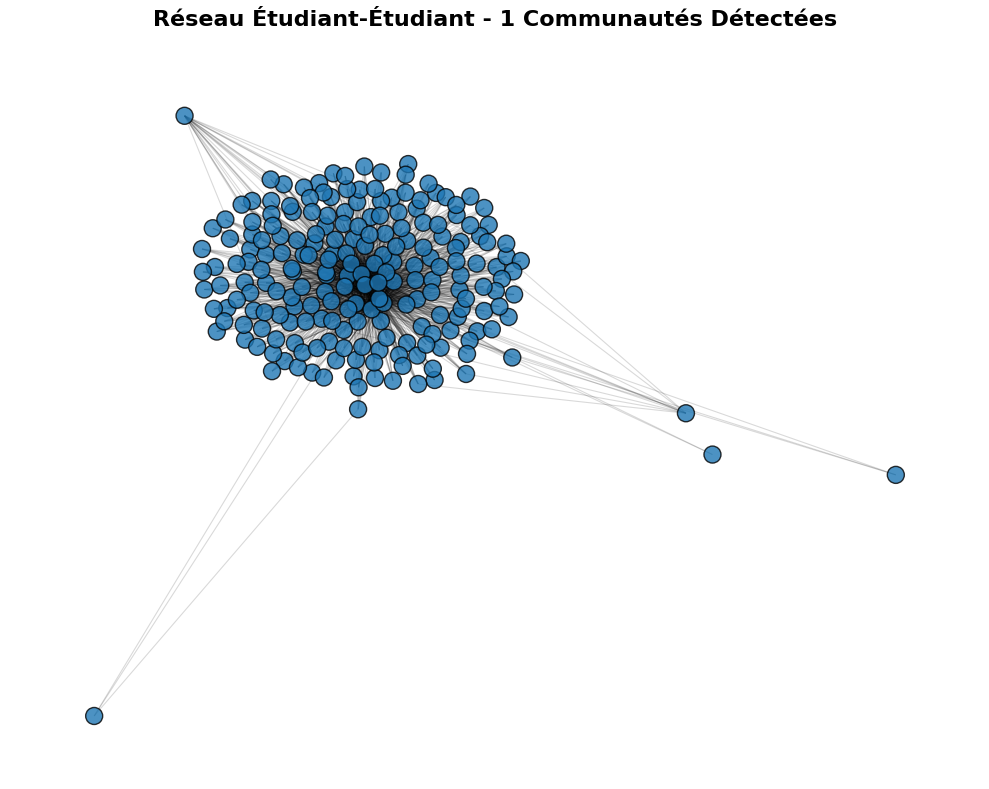

In [48]:
fig, ax = plt.subplots(figsize=(10, 8))

# Layout
pos = nx.spring_layout(G_proj, k=0.3, iterations=50, seed=42)

# Couleurs
if communities:
    # Colorier par communauté
    node_colors = [communities.get(node, 0) for node in G_proj.nodes()]
    cmap = plt.cm.tab10
    title = f"Réseau Étudiant-Étudiant - {len(set(communities.values()))} Communautés Détectées"
else:
    # Colorier par résultat
    result_colors = {'Distinction': 0, 'Pass': 1, 'Fail': 2, 'Withdrawn': 3}
    node_colors = [result_colors.get(G_proj.nodes[node].get('final_result', 'Fail'), 4) 
                  for node in G_proj.nodes()]
    cmap = plt.cm.Set1
    title = "Réseau Étudiant-Étudiant (par résultat final)"

# Dessiner
nx.draw_networkx_nodes(G_proj, pos, node_color=node_colors, 
                      node_size=150, alpha=0.8, cmap=cmap, ax=ax, 
                      edgecolors='black', linewidths=1)

nx.draw_networkx_edges(G_proj, pos, alpha=0.15, width=0.8, ax=ax)

ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
ax.axis('off')
plt.tight_layout()

In [59]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np

n_clusters = 4
activity_summary = interactions[['id_student', 'activity_type', 'sum_click', 'final_result']]
# Créer la matrice étudiant × activité
students = activity_summary['id_student'].unique()
activities = activity_summary['activity_type'].unique()

matrix = np.zeros((len(students), len(activities)))
student_to_idx = {s: i for i, s in enumerate(students)}
activity_to_idx = {a: i for i, a in enumerate(activities)}

for _, row in activity_summary.iterrows():
    i = student_to_idx[row['id_student']]
    j = activity_to_idx[row['activity_type']]
    matrix[i, j] = row['sum_click']

# Normaliser
scaler = StandardScaler()
matrix_scaled = scaler.fit_transform(matrix)

# K-Means
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(matrix_scaled)

# Analyser les clusters
cluster_data = []
for idx, student in enumerate(students):
    student_info = activity_summary[activity_summary['id_student'] == student].iloc[0]
    cluster_data.append({
        'student': student,
        'cluster': clusters[idx],
        'final_result': student_info['final_result']
    })

df_clusters = pd.DataFrame(cluster_data)

print(f"   → Inertie : {kmeans.inertia_:.0f}")
print(f"   → Distribution : {df_clusters['cluster'].value_counts().to_dict()}\n")

# Analyser chaque cluster
print("Profil des clusters:")
for cluster_id in range(n_clusters):
    cluster_subset = df_clusters[df_clusters['cluster'] == cluster_id]
    result_dist = cluster_subset['final_result'].value_counts()
    pass_rate = (result_dist.get('Pass', 0) + result_dist.get('Distinction', 0)) / len(cluster_subset) * 100
    
    print(f"\n--- Cluster {cluster_id} ({len(cluster_subset)} étudiants) ---")
    print(f"Résultats: {result_dist.to_dict()}")
    print(f"Taux de réussite: {pass_rate:.1f}%")
    
    # Profil d'usage (centroïde)
    centroid = kmeans.cluster_centers_[cluster_id]
    top_activities = sorted(zip(activities, centroid), key=lambda x: x[1], reverse=True)[:3]
    print(f"Top 3 activités: {[a[0] for a in top_activities]}")

c:\Users\HP.LAPTOP-ESRMF9MQ\anaconda3\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


   → Inertie : 1302
   → Distribution : {0: 154, 3: 40, 2: 3, 1: 3}

Profil des clusters:

--- Cluster 0 (154 étudiants) ---
Résultats: {'Pass': 99, 'Distinction': 39, 'Fail': 10, 'Withdrawn': 6}
Taux de réussite: 89.6%
Top 3 activités: ['glossary', 'ouwiki', 'externalquiz']

--- Cluster 1 (3 étudiants) ---
Résultats: {'Withdrawn': 2, 'Fail': 1}
Taux de réussite: 0.0%
Top 3 activités: ['questionnaire', 'oucontent', 'quiz']

--- Cluster 2 (3 étudiants) ---
Résultats: {'Pass': 2, 'Withdrawn': 1}
Taux de réussite: 66.7%
Top 3 activités: ['externalquiz', 'ouwiki', 'oucollaborate']

--- Cluster 3 (40 étudiants) ---
Résultats: {'Pass': 27, 'Distinction': 7, 'Fail': 3, 'Withdrawn': 3}
Taux de réussite: 85.0%
Top 3 activités: ['homepage', 'subpage', 'quiz']


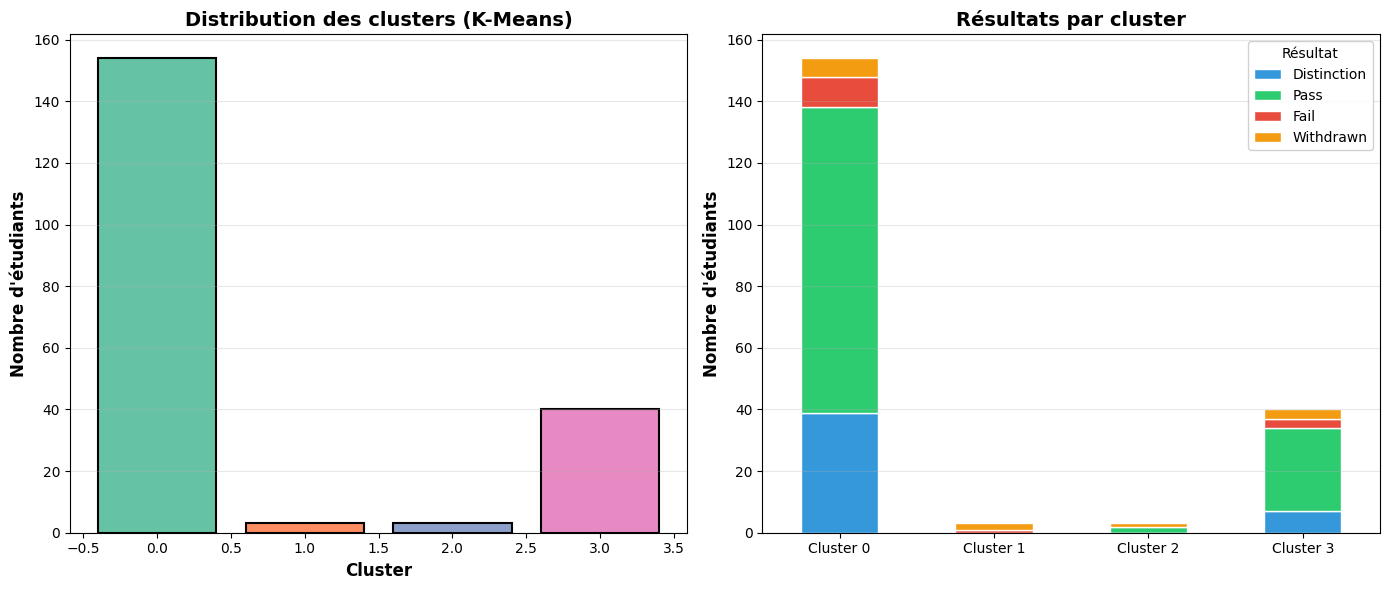

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. Taille des clusters
cluster_counts = df_clusters['cluster'].value_counts().sort_index()
colors = plt.cm.Set2(range(len(cluster_counts)))

axes[0].bar(cluster_counts.index, cluster_counts.values, 
           color=colors, edgecolor='black', linewidth=1.5)
axes[0].set_xlabel('Cluster', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Nombre d\'étudiants', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution des clusters (K-Means)', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# 2. Taux de réussite par cluster
success_data = []
for cluster_id in sorted(df_clusters['cluster'].unique()):
    cluster_subset = df_clusters[df_clusters['cluster'] == cluster_id]
    result_dist = cluster_subset['final_result'].value_counts()
    
    for result in ['Distinction', 'Pass', 'Fail', 'Withdrawn']:
        count = result_dist.get(result, 0)
        success_data.append({
            'cluster': f'Cluster {cluster_id}',
            'result': result,
            'count': count
        })

df_success = pd.DataFrame(success_data)
pivot = df_success.pivot(index='cluster', columns='result', values='count').fillna(0)

result_colors = {'Distinction': '#3498db', 'Pass': '#2ecc71', 
                'Fail': '#e74c3c', 'Withdrawn': '#f39c12'}

pivot[['Distinction', 'Pass', 'Fail', 'Withdrawn']].plot(
    kind='bar', stacked=True, ax=axes[1], 
    color=[result_colors[r] for r in ['Distinction', 'Pass', 'Fail', 'Withdrawn']],
    edgecolor='white', linewidth=1
)

axes[1].set_xlabel('', fontsize=12)
axes[1].set_ylabel('Nombre d\'étudiants', fontsize=12, fontweight='bold')
axes[1].set_title('Résultats par cluster', fontsize=14, fontweight='bold')
axes[1].legend(title='Résultat', framealpha=0.9)
axes[1].grid(axis='y', alpha=0.3)
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()